**Author**: Ivan Maksimov (Ivan.Maksimov@skoltech.ru, telegram - @Ivan_maksimov)  
**Topic**: Dish tagging  
**Detailed topic description**: Tag dishes based on dish description and receipt  
**Methodology**: 
- Fit baseline (Multinomial NB)
- Fit word embedding + classifier on top 
- Fit Bi-directional LSTM embedding + classifier on top
- Try pretrained embeddinbgs

**Data**: taken from an open food databese: https://world.openfoodfacts.org/data. Btw, it is easier to download the same dataset from Kaggle: https://www.kaggle.com/openfoodfacts/world-food-facts 
  
**Target metric**: F1-score with weighted averaging. Weighted - as there is class imbalance

In [ ]:
!conda create -n nnlp_project python=3.7 anaconda
!conda activate nnlp_project
!pip install seaborn
!pip install tqdm
!conda install pytorch torchvision -c pytorch

In [15]:
import re
from collections import Counter
from IPython.display import clear_output, HTML, display_html

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from tqdm import tnrange

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from src.data_cleansing import clean

%matplotlib inline

pd.set_option('display.max_columns', 200)

## 1. Data reading and cleansing
## 1. Data reading and cleansing

In [2]:
df = pd.read_csv('raw_data/en.openfoodfacts.org.products.tsv', sep='\t')

df = clean(df)

//anaconda3/envs/nnlp_project/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


full data count: 356027
taking into account only dishes with product names: 338515
taking into account only dishes with ingredients info: 282097
taking into account only dishes with category: 86605
taking into account only dishes with category in English: 83898
taking into account only categories with value_count > 300: 79906
taking into account only non-confusing categories: 79072
taking into account only dishes with correct product_name (product name length >= 3): 79065
taking into account only dishes with correct ingredients_text (ingredients text length >= 5): 78681


**Note:** "en:category_name" is a standartized category in english across all categories and languages

In [3]:
df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
176,290616,http://world-en.openfoodfacts.org/product/0000...,b7,1484605978,2017-01-16T22:32:58Z,1484606542,2017-01-16T22:42:22Z,Salade Cesar,Laitue en salade,0.980 kg,Frais,frais,Kirkland Signature,kirkland-signature,Légumes-feuilles,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",Québec,quebec,Brossard Québec,brossard-quebec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Costco,Canada,en:canada,Canada,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,NaN,NaN,CONTIENT : OEUF. LAIT. ANCHOIS. SOYA. BLE. SEI...,fr:contient-oeuf-lait-anchois-soya-ble-seigle-...,fr:Contient-oeuf-lait-anchois-soya-ble-seigle-...,100 g,NaN,0.0,[ ingredients -> fr:ingredients ] [ laitue-...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,c,Fruits and vegetables,Vegetables,"en:to-be-checked, en:complete, en:nutrition-fa...","en:to-be-checked,en:complete,en:nutrition-fact...","To be checked,Complete,Nutrition facts complet...",en:plant-based-foods-and-beverages,Plant-based foods and beverages,NaN,NaN,1210.0,NaN,12.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0560,23.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,22.00,NaN,NaN,NaN,2.160,0.850,NaN,0.000000,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,N

Hmm.. looks like a lot of products are from France as their product_names and ingredient_text are in french

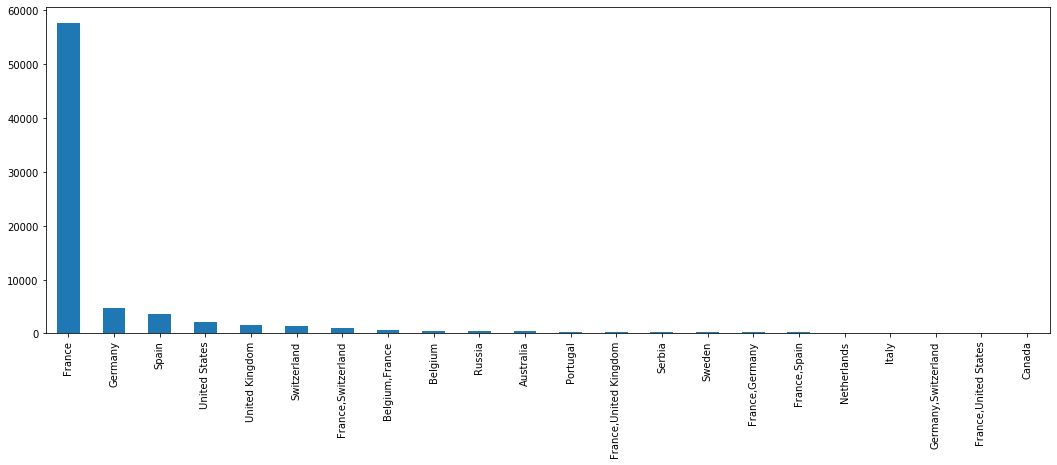

In [4]:
plt.figure(figsize=(18,6))
df.countries_en.value_counts()[df.countries_en.value_counts() > 100].plot(kind='bar')
plt.show()

In [5]:
df = df[df['countries_en'].isin(['France'])]
print('taking into account only dishes from France: {}'.format(df.shape[0]))

print('-----------------------')
N_CLASSES = df.main_category.nunique()
print('Number of final categories: {}'.format(N_CLASSES))

taking into account only dishes from France: 57662
-----------------------
Number of final categories: 20


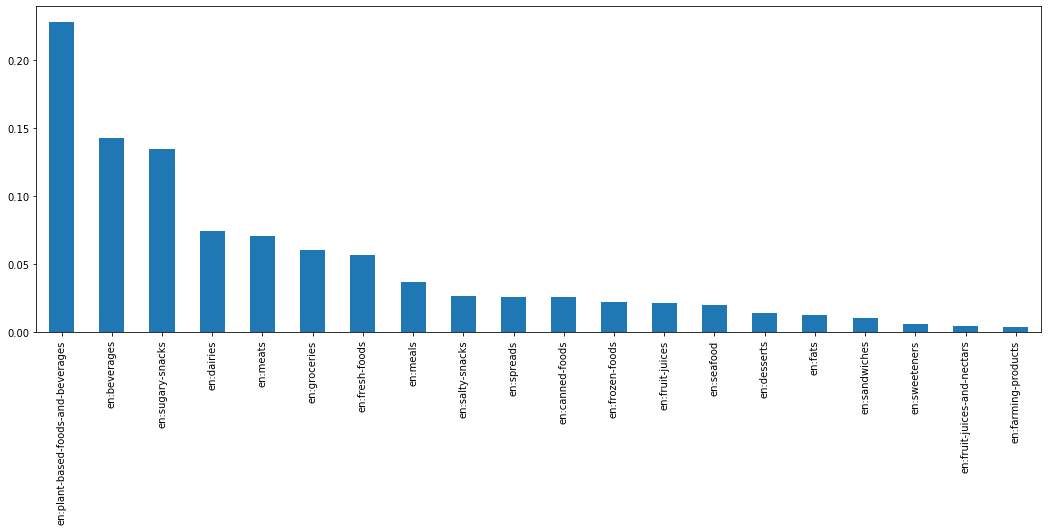

In [6]:
plt.figure(figsize=(18,6))
df.main_category.value_counts(normalize=True).plot(kind='bar')
plt.show()

## 2. Data preparation

Let's take only Product name and Ingredient info columns

In [7]:
columns = ['main_category', 'product_name', 'ingredients_text']
df = df[columns]

### 2.1 Text to lowercase

In [8]:
for col in df.columns:
    df[col] = df[col].str.lower()

In [9]:
df.tail(5)

,main_category,product_name,ingredients_text
355977,en:beverages,ma bite,du sperme de la viande du viagra
355978,en:fats,les schtroumpfs & le village des fille,"les schtroumpfs t, les schtroumpfs noirs 2. le..."
355997,en:groceries,gingembre,gingembre
356017,en:beverages,thé vert earl grey,"thé vert, arôme naturel bergamote avec autres ..."
356019,en:meats,rillette d'oie,"viande d'oie, graisse de canard, épices, sel, ..."


### 2.2 Drop specific symbols (_, (, ), etc )

In [10]:
for col in df.columns[1:]:
    
    df[col] = df[col].str.replace('_', '')
    df[col] = df[col].str.replace('(', '')
    df[col] = df[col].str.replace(')', '')
    df[col] = df[col].str.replace(':', '')

In [11]:
df.tail(5)

,main_category,product_name,ingredients_text
355977,en:beverages,ma bite,du sperme de la viande du viagra
355978,en:fats,les schtroumpfs & le village des fille,"les schtroumpfs t, les schtroumpfs noirs 2. le..."
355997,en:groceries,gingembre,gingembre
356017,en:beverages,thé vert earl grey,"thé vert, arôme naturel bergamote avec autres ..."
356019,en:meats,rillette d'oie,"viande d'oie, graisse de canard, épices, sel, ..."


### 2.3 Replace multiple spaces by a single one, surround non-alphanumeric symbols with spaces

In [12]:
def prepare(text):
    """Note: French words like "l'amoure" contains "'", that we should not drop or surround by spaces as
    it may change the sense of word"""
    
    text = ''.join((' {} '.format(word) if not word.isalpha() else word for word in text))
    text = re.sub('(\s+)', ' ', text) #multiple spaces are replaced by single space
    return text

df['product_name'] = df['product_name'].apply(prepare)
df['ingredients_text'] = df['ingredients_text'].apply(prepare)

In [13]:
df.tail(3)

,main_category,product_name,ingredients_text
355997,en:groceries,gingembre,gingembre
356017,en:beverages,thé vert earl grey,"thé vert , arôme naturel bergamote avec autres..."
356019,en:meats,rillette d ' oie,"viande d ' oie , graisse de canard , épices , ..."


## 3. Baseline - Naive Bayes

### 3.1 Based on only product name

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['product_name'], df['main_category'],
                                                    test_size=0.2,
                                                    random_state = 42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
print(clf.predict(tfidf.transform(["rillette d ' oie"])))   # Утиный паштет

['en:meats']


In [18]:
print(clf.predict(tfidf.transform(["thé vert earl grey"])))   # Чай "Earl grey"

['en:beverages']


**Comment:** Sounds pretty good!
- duck pate --> meats
- tea --> beverages

In [19]:
y_pred = clf.predict(tfidf.transform(X_test))

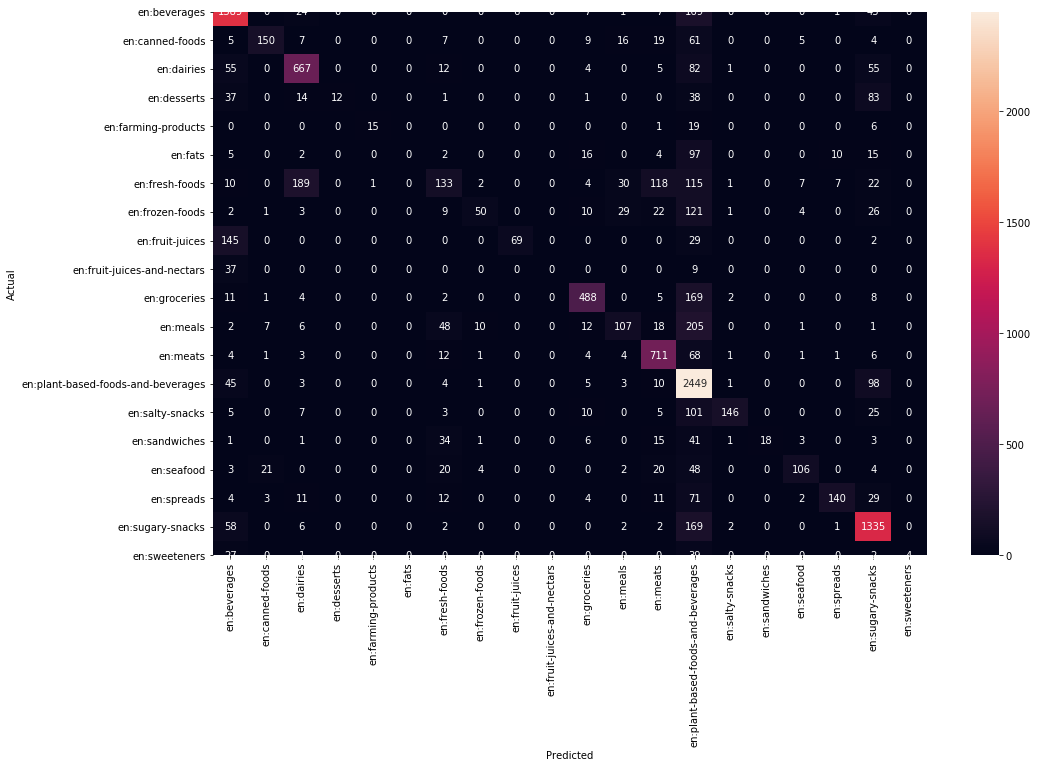

In [20]:
mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(mat, annot=True, fmt='d',
            xticklabels=np.unique(y_test).tolist(), 
            yticklabels=np.unique(y_test).tolist()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
test_f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
test_accuracy = (y_pred == y_test).sum() / len(y_test)

print('Test F1-score: {:.2f}'.format(test_f1_score))
print('Test accuracy: {:.2f}'.format(test_accuracy))
print('--------------------')
print('(!) Note that for multiclass classification the lower bound (random guess) is a share of most frequent category.\
      in our example this share is equal to 0.22')

Test F1-score: 0.66
Test accuracy: 0.69
--------------------
(!) Note that for multiclass classification the lower bound (random guess) is a share of most frequent category.      in our example this share is equal to 0.22


In [23]:
print(metrics.classification_report(
    y_test, y_pred, 
    #target_names=df['main)category'].unique()
    ))

//anaconda3/envs/nnlp_project/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                    precision    recall  f1-score   support

                      en:beverages       0.75      0.84      0.80      1649
                   en:canned-foods       0.82      0.53      0.64       283
                        en:dairies       0.70      0.76      0.73       881
                       en:desserts       1.00      0.06      0.12       186
               en:farming-products       0.94      0.37      0.53        41
                           en:fats       0.00      0.00      0.00       151
                    en:fresh-foods       0.44      0.21      0.28       639
                   en:frozen-foods       0.72      0.18      0.29       278
                   en:fruit-juices       0.92      0.28      0.43       245
       en:fruit-juices-and-nectars       0.00      0.00      0.00        46
                      en:groceries       0.84      0.71      0.77       690
                          en:meals       0.55      0.26      0.35       417
           

### 3.2 Based on only ingredient info

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['ingredients_text'], df['main_category'], 
                                                    test_size=0.2,
                                                    random_state = 42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

y_pred = clf.predict(tfidf.transform(X_test))

test_f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
test_accuracy = (y_pred == y_test).sum() / len(y_test)

print('Test F1-score: {:.2f}'.format(test_f1_score))
print('Test accuracy: {:.2f}'.format(test_accuracy))
print('--------------------')
print('(!) Note that for multiclass classification the lower bound (random guess) is a share of most frequent category.\
      in our example this share is equal to 0.22')

print(metrics.classification_report(
    y_test, y_pred, 
    #target_names=df['main)category'].unique()
    ))

//anaconda3/envs/nnlp_project/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/envs/nnlp_project/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test F1-score: 0.56
Test accuracy: 0.63
--------------------
(!) Note that for multiclass classification the lower bound (random guess) is a share of most frequent category.      in our example this share is equal to 0.22
                                    precision    recall  f1-score   support

                      en:beverages       0.74      0.85      0.79      1649
                   en:canned-foods       0.87      0.25      0.39       283
                        en:dairies       0.68      0.71      0.70       881
                       en:desserts       0.00      0.00      0.00       186
               en:farming-products       1.00      0.02      0.05        41
                           en:fats       0.00      0.00      0.00       151
                    en:fresh-foods       0.27      0.09      0.14       639
                   en:frozen-foods       0.17      0.00      0.01       278
                   en:fruit-juices       1.00      0.01      0.02       245
       en:fruit-j

## 4. Neural Models

In [28]:
token_counts = Counter()

for name in list(df['product_name'].values):
    token_counts.update(name.split(" "))
for ingredients in list(df['ingredients_text'].values):
    token_counts.update(ingredients.split(" "))
    
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))

Total unique tokens : 42951
(',', 528018)
('de', 246913)
('%', 102734)
('.', 70936)
('1', 58103)


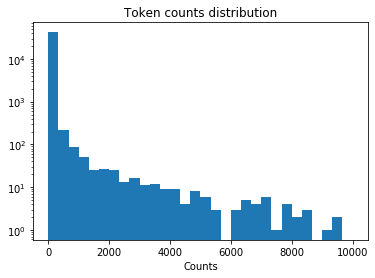

In [29]:
_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=30, log=True)
plt.xlabel("Counts")
plt.title('Token counts distribution')
plt.show()

In [30]:
MIN_COUNT = 3

# List of tokens with count >= MIN_COUNT, and special symbols
tokens = [k for k, v in token_counts.items() if v >= MIN_COUNT] 

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

# Inverse token dict
token_to_id = {x:idx for idx, x in enumerate(tokens)}

In [31]:
category_to_idx = {}
idx_to_category = {}
for idx, category in enumerate(df.main_category.unique().tolist()):
    category_to_idx.update({category: idx})
    idx_to_category.update({idx: category})

In [32]:
df['main_category'] = df['main_category'].map(category_to_idx)

In [33]:
# Convert input text to torch matrix

UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=30):
    """ Convert a list of tokens into a matrix with padding """
#     if isinstance(sequences[0], str):
#         sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix


def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """Creates a pytorch-friendly dict from the batch data"""
    
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in TEXT_COLUMNS:
        batch[col] = as_matrix(data[col].values, max_len)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return batch

In [34]:
data_train, data_val = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
TEXT_COLUMNS = ['ingredients_text', 'product_name']
TARGET_COLUMN = 'main_category'

In [36]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]
    
    
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embedding_type='linear'):
        """x -> emb -> conv -> global_max -> relu -> dense"""
        
        super(self.__class__, self).__init__()
        
        self.embedding_type=embedding_type
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        
        # For LSTM
        if embedding_type == 'bidirectional_lstm':
            self.lstm = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True, bidirectional=True)
            self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        
        # For Linear
        if embedding_type == 'linear':
            self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
            
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):

        h = self.emb(text_ix)
        
        if self.embedding_type == 'bidirectional_lstm':
            h, _ = self.lstm(h)
           
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
            
        return h
    
    
class IngredientsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embedding_type='linear'):
        """x -> emb -> conv -> global_max -> relu -> dense"""
        
        super(self.__class__, self).__init__()
        
        self.embedding_type=embedding_type
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        
        # For LSTM
        if embedding_type == 'bidirectional_lstm':
            self.lstm = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True, bidirectional=True)
            self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        
        # For Linear
        if embedding_type == 'linear':
            self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
            
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()
            

    def forward(self, text_ix):

        h = self.emb(text_ix)
        
        if self.embedding_type == 'bidirectional_lstm':
            h, _ = self.lstm(h)
            
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)

        return h
    
    
class FullNetwork(nn.Module):
    """This class does all the steps from (title, ingredients) features -> predicted target"""
    
    def __init__(self, n_tokens=len(tokens), n_outputs=N_CLASSES, embedding_type='linear'):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(embedding_type=embedding_type, out_size=64)
        self.ingredients_encoder = IngredientsEncoder(embedding_type=embedding_type, out_size=64)

        self.comb1_linear = nn.Linear(64+64, 64)
        self.relu = nn.ReLU()
        self.comb2_linear = nn.Linear(64, n_outputs)
        
        
    def forward(self, title_ix, desc_ix):
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.ingredients_encoder(desc_ix)
        
        # concatenate all vectors together
        joint_h = torch.cat([title_h, desc_h], dim=1)
        
        joint_h = self.comb1_linear(joint_h)
        joint_h = self.relu(joint_h)
        joint_h = self.comb2_linear(joint_h)
        
#         joint_h.exp_()
#         joint_h = joint_h / joint_h.sum(dim=1, keepdim=True)
        
        # No output nonlinearities as we use cross_entropy loss (nn.CrossEntropyLoss)
        outputs = F.softmax(joint_h)
        return outputs 

In [37]:
def iterate_minibatches(df, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(df))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(df.iloc[indices[start : start + batch_size]], max_len=max_len)
        
        
cross_entropy = nn.BCELoss()
def loss_func(target, output):
    target = torch.nn.functional.one_hot(target, N_CLASSES).float()
    loss = cross_entropy(output, target)
    return loss

In [39]:
def train(model, optimizer):
    train_bce_list = []
    train_f1_list = []

    for epoch_i in range(num_epochs):

        print("Training:")
        train_loss = train_f1= train_batches = 0    
        model.train(True)

        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
            title_ix = torch.tensor(batch["product_name"], dtype=torch.int64)
            ingredients_ix = torch.tensor(batch["ingredients_text"], dtype=torch.int64)
            reference = torch.tensor(batch[TARGET_COLUMN])

            prediction = model(title_ix, ingredients_ix)
            prediction_labels = prediction.argmax(dim=1)

            loss = loss_func(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.data.numpy()  #[0]
            train_f1 += metrics.f1_score(reference, prediction_labels, average='weighted')
            train_batches += 1


        train_bce_list.append(train_loss / train_batches)
        train_f1_list.append(train_f1 / train_batches)

        clear_output()
        fig, ax = plt.subplots(figsize = (20, 6), ncols= 2, nrows = 1)
        ax[0].plot(train_bce_list, label = 'Train BCE', color = 'blue')
        ax[0].legend()
        ax[0].set_ylabel('Train BCE')

        ax[1].plot(train_f1_list, label = 'Train F1-score', color = 'blue')
        ax[1].legend()
        ax[1].set_ylabel('Train F1-score')

        plt.show()


    print("Testing:")
    val_loss = val_f1 = val_batches = 0
    model.train(False)

    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["product_name"], dtype=torch.int64)
        ingredients_ix = torch.tensor(batch["ingredients_text"], dtype=torch.int64)
        reference = torch.tensor(batch[TARGET_COLUMN])

        prediction = model(title_ix, ingredients_ix)
        prediction_labels = prediction.argmax(dim=1)

        loss = loss_func(reference, prediction)
        val_loss += loss.data.numpy()  
        val_f1 += metrics.f1_score(reference, prediction_labels, average='weighted')
        val_batches += 1

    print("\tTest Loss:\t%.5f" % (val_loss / val_batches))
    print("\tTest F1-score:\t%.5f" % (val_f1 / val_batches))
    print('\n\n')

### 4.1 Word Embedding + Conv1D + MaxPooling

In [40]:
num_epochs = 50
max_len = 30
batch_size = 32
batches_per_epoch = 100

In [41]:
model = FullNetwork(embedding_type='linear')
opt = torch.optim.Adam(model.parameters(), 
                       lr=1e-3, 
                       weight_decay=1e-5)

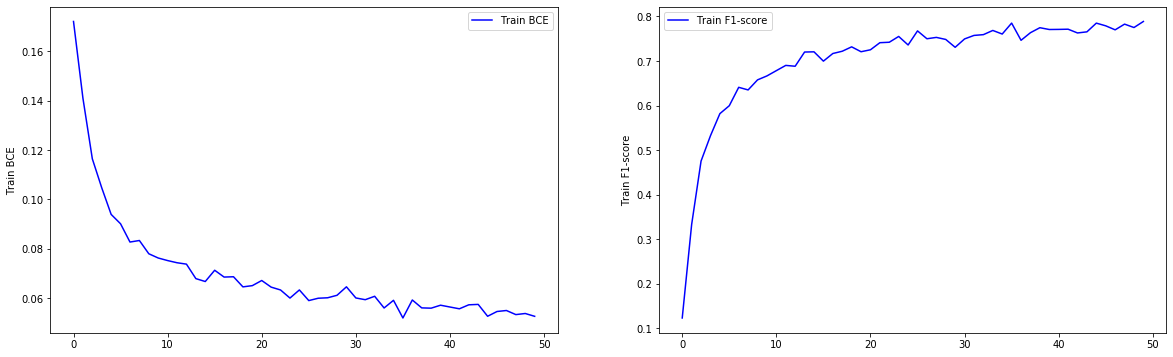

Testing:



	Test Loss:	0.05822
	Test F1-score:	0.76388





In [42]:
train(model, opt)

---

### 4.2 Biderectional LSTM

In [43]:
model_bilstm = FullNetwork(embedding_type='bidirectional_lstm')
opt = torch.optim.Adam(model_bilstm.parameters(), 
                       lr=1e-3, 
                       weight_decay=1e-5)

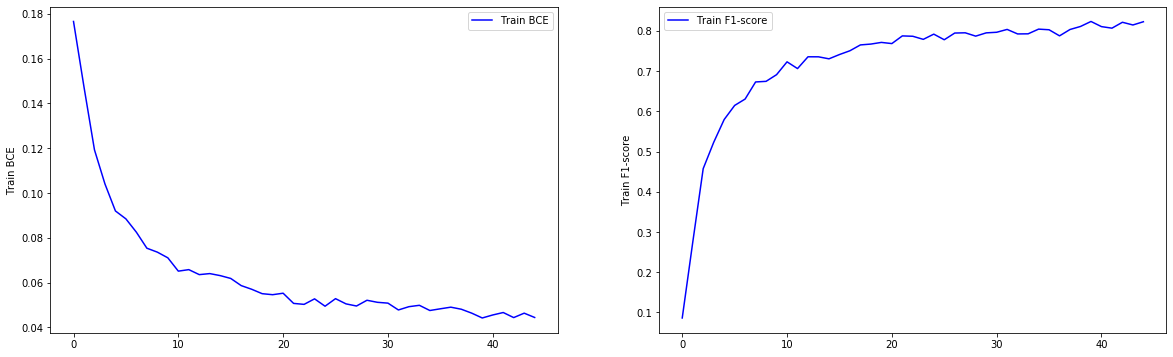

Training:


In [ ]:
train(model_bilstm, opt)

## 5. Explain model results

Let's calculate how dropping a word from Product name or Ingredients info influence model predictions.   
I will calculate the norm of difference between predeicted probabilities without dropping a word and with it

In [ ]:
def explain(model, sample, col_name='product_name'):
    """ Computes the effect each word had on model predictions """
    
    sample = pd.DataFrame(sample).T
    batch = generate_batch(sample)
    title_ix = torch.tensor(batch["product_name"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["ingredients_text"], dtype=torch.int64)
    
    baseline_pred = model(title_ix, desc_ix).detach().numpy()[0]
    predictions_without_word = []
    
    tokens = str(sample[col_name].values[0]).split()
    for i in range(len(tokens)):
        sample_without_word = pd.DataFrame(sample.copy())
        tokens_without_word = tokens.copy()
        tokens_without_word[i] = UNK
        sample_without_word[col_name].values[0] = ' '.join(tokens_without_word)
        batch_without_word = generate_batch(sample_without_word)
        
        title_ix_without_word = torch.tensor(batch_without_word["product_name"], dtype=torch.int64)
        desc_ix_without_word = torch.tensor(batch_without_word["ingredients_text"], dtype=torch.int64)

        predictions_without_word.append(model(title_ix_without_word, desc_ix_without_word).detach().numpy()[0])

    score_differences = [
        ((prediction - baseline_pred)**2).sum().sum() for prediction in predictions_without_word
    ]
    
    return list(zip(tokens, score_differences)) 


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html


def run_explanation(model, sample):
    batch = generate_batch(pd.DataFrame(sample).T)
    title_ix = torch.tensor(batch["product_name"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["ingredients_text"], dtype=torch.int64)

    prediction = model.forward(title_ix, desc_ix).argmax(dim=1).numpy()[0]
    prediction_category = idx_to_category[prediction]
    true_category = idx_to_category[sample['main_category']]

    print('True category:', true_category)
    print('Predicted category:', prediction_category)

    tokens_and_weights_name = explain(model, sample, "product_name")
    tokens_and_weights_ingredients = explain(model, sample, "ingredients_text")
    
    sum_weight_name = np.sum([weight for tok, weight in tokens_and_weights_name])
    sum_weight_ingredient = np.sum([weight for tok, weight in tokens_and_weights_ingredients])
    sum_weight_total = sum_weight_name + sum_weight_ingredient
    
    draw_html([(tok, weight / sum_weight_total) for tok, weight in tokens_and_weights_name], font_style='font-size:20px;');
    draw_html([(tok, weight / sum_weight_total) for tok, weight in tokens_and_weights_ingredients]);


**Note:**  
The effect of dropping is normalized to 100% by dividing "dropping a word effect" by sum of ALL effets (from both product name and ingredients test) of word dropping   
  
So, the darker a word is, the more important it is. Also we can compare Product name & Ingredients importance 

## Analysis of correct examples

In [ ]:
sample = df.iloc[3, :]

run_explanation(model_bilstm, sample)

**Comment:** Seems Okay. The model suggests the word thé (tea) the most important

In [ ]:
sample = df.iloc[2, :]

run_explanation(model_bilstm, sample)

**Comment:** Biscuits and sucre (sugar) are the most important for "en:sugary-snacks" category - perfect)

In [ ]:
sample = df.iloc[8, :]

run_explanation(model_bilstm, sample)

**Comment: (!)**  A perfect example! Product name is a very rare word (7 Up). It is not a dish indeed. But still with ingredients info we can correctly classify it

In [ ]:
sample = df.iloc[16339, :]

run_explanation(model_bilstm, sample)

In [ ]:
sample = df.iloc[21542, :]

run_explanation(model_bilstm, sample)

## Analysis of predictions with errors

In [ ]:
sample = df.iloc[16486, :]

run_explanation(model_bilstm, sample)

**Comment: (!)**  Predicted category is "meats" as the model saw the word "viande" (which means meat in french) 
and the word "poulet" (chicken). So, this example is really confusing

In [ ]:
sample = df.iloc[8051, :]

run_explanation(model_bilstm, sample)

**Comment:**  Also a pretty confusing example: Title is just made of pretty words "flower of a duck". Moreover, such
words as fleuron (flower), huile (butter), poivre (pepper) do not point on meat category

## Just to play with random dishes :)

In [ ]:
i = np.random.randint(len(df)) // 2
sample = df.iloc[i, :]
print(i)

run_explanation(model_bilstm, sample)

## 5. Results & Conclusion

**Notes on data preprocessing:** 
- Data preparation and cleansing matters a LOT
- Tried to split ingredients text by comma (word = ingredient, that can contain multiple words) - decreased performance. Probably, many ingredients (several words = one ingredient) arte too rare

**Notes on model performance:**
- **Multinomial NB:** 66% F1-score, NEVER predicts several rare catagories 
- **Word Embedding + Conv1D + MaxPool (Word embedding)**: performs much better than NB (76% F1 score). Is pretty fast. However, unable to capture word context, which could be important in this task
- The best model in terms of F1-score is **Bidirectional LSTM** (F1-score ~ 79%). However, it is the slowest model in terms of both training and prediction. Interseting, that in terms of F1-score Bi-LSTM > Word Embedding >> Multinomial NB. But in terms of training and inference speed Multinomial NB > Word Embedding >> Bi-LSTM. Probably, I should use QRNN, but I found only non-official (not from pytorch.org) implementations which performed strangely (with very high loss variance)

**Notes on Neural Models:**
- Pretrained embeddings did not work (F1-score decreased a bit). Probably, dataset is very domain-specific. Moreover, data is pretty dirty. For example, sometimes there are english words (not french) or dish logos instead of normal dish names. I tried GLOVE embeddings for french language from https://github.com/HIT-SCIR/ELMoForManyLangs/blob/master/README.md 
- Bidirectional LSTM yields better score than just word embedding NN, but is much slower
- Bidirectional LSTM is able to catch word sence in the context (see model explanation part). I suppose it is the reason for improved performance in comparizon to word embeddings (79% vs 76%)

**And finally:**  
Use Neural NLP methods - they are really cool and outperform standard methods:)  
However, be careful: 
- Preprocessing data is a must
- train models on GPU (8-10x faster)
- use optimized layers
- Word context matters, so lstms, attention, transfotmers could really improve your models